In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Loading data

In [11]:
NUM_SAMPLES = 10000

input_texts = []
target_texts = []
target_texts_inputs = []

In [12]:
t = 0

with open("../neural_machine_translation/data/hin.txt") as f:
    for line in f:
        
        # keeping only limited number of samples
        t += 1
        if t > NUM_SAMPLES:
            break
            
        if '\t' not in line:
            continue
            
        input_text, translation, *rest = line.rstrip().split('\t')
        
        target_text = translation + ' <eos>'
        target_text_input = '<sos> ' + translation
        
        input_texts.append(input_text)
        target_texts.append(target_text)
        target_texts_inputs.append(target_text_input)
    

In [13]:
target_texts_input[:15]

['<sos> वाह!',
 '<sos> झुको!',
 '<sos> बतख़!',
 '<sos> बचाओ!',
 '<sos> उछलो.',
 '<sos> कूदो.',
 '<sos> छलांग.',
 '<sos> नमस्ते।',
 '<sos> नमस्कार।',
 '<sos> वाह-वाह!',
 '<sos> चियर्स!',
 '<sos> सांस छोड़।',
 '<sos> सांस छोड़ो।',
 '<sos> समझे कि नहीं?',
 '<sos> मैं ठीक हूँ।']

### Tokenizers and word to index mappings

#### I have two languages to deal with, hence need two different tokenizers

In [14]:
print(input_texts[:5])

['Wow!', 'Duck!', 'Duck!', 'Help!', 'Jump.']


In [15]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from itertools import islice

MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100

In [16]:
# tokenizer for inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
print(input_sequences[:7])


# word_to_index mapping 
word_to_idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens' % len(word_to_idx_inputs))
first_10_mapping_inputs = dict(islice(word_to_idx_inputs.items(), 10))
first_10_mapping_inputs


# maximum length of input sequences
max_len_inputs = max(len(i) for i in input_sequences)
print("Maximum length of input sequences:",max_len_inputs)

[[1326], [949], [949], [83], [582], [582], [582]]
Found 2463 unique input tokens
Maximum length of input sequences: 22


In [18]:
# tokenizer for outputs
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_input)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)
print(target_sequences[:5])
print(target_sequences_inputs[:5])


# word to index mapping
word_to_idx_outputs = tokenizer_outputs.word_index
print("Found %s unique output tokens" % len(word_to_idx_outputs))
first_10_mappings_outputs = dict(islice(word_to_idx_outputs.items(), 10))
first_10_mappings_outputs


# maximum length of output sequences
max_len_target = max(len(i) for i in target_sequences)
print("Maximum length of output sequences:",max_len_target)


[[1538, 1], [1539, 1], [1540, 1], [1541, 1], [1542, 1]]
[[2, 1538], [2, 1539], [2, 1540], [2, 1541], [2, 1542]]
Found 3265 unique output tokens
Maximum length of output sequences: 26


In [19]:
num_words_output = len(word_to_idx_outputs) + 1
num_words_output

3266

### Pad each sequence

In [22]:
# padding for encoder inputs
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_inputs)
print("Encoder input shape is", encoder_inputs.shape)
encoder_inputs[0]

Encoder input shape is (3061, 22)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1326],
      dtype=int32)

#### Upon seeing the encoder state/the last word of the input sequence, the decoder produces the output immediately rather than having to go through a bunch of zeros first, hence post padding for decoder

In [25]:
# padding for decoder inputs and targets
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("Decoder input shape is", decoder_inputs.shape)
print(decoder_inputs[0])

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("Decoder target shape is", decoder_targets.shape)
print(decoder_targets[0])

Decoder input shape is (3061, 26)
[   2 1538    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Decoder target shape is (3061, 26)
[1538    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Storing pre-trained vectors

In [26]:
EMBEDDING_DIM = 100

print("Filling pre-trained embeddings...")

Filling pre-trained embeddings...


In [28]:
# os.getcwd() + '/glove'

In [29]:
word_to_vec = {}
with open(os.path.join(os.getcwd() + '/glove/glove.6B.%sd.txt' %EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word_to_vec[word] = vec
        
print('Found %s word vectors' %len(word_to_vec))

Found 400000 word vectors


In [30]:
from itertools import islice

first_2_vecs = dict(islice(word_to_vec.items(), 2))
print('Vector length is', len(list(first_2_vecs.items())[0][1]))
first_2_vecs

Vector length is 100


{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

### Embedding Matrix

In [31]:
MAX_NUM_WORDS = 20000

In [32]:
num_words = min(MAX_NUM_WORDS, len(word_to_idx_inputs) + 1)
embedding_matrix = np.zeros(shape=(num_words, EMBEDDING_DIM))
embedding_matrix.shape

for word, i in word_to_idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word_to_vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(2464, 100)

### Embedding layer

In [34]:
from keras.layers import Embedding

embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length = max_len_inputs)

### One-hot encoded target

#### Creating targets and since the targets are sequences, I can not use sparse categorical cross entropy 

In [36]:
print(len(input_texts))
print(max_len_target)
print(num_words_output)
print(decoder_targets.shape)

3061
26
3266
(3061, 26)


In [39]:
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')
decoder_targets_one_hot

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [41]:
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        if word != 0:
            decoder_targets_one_hot[i, t, word] = 1
            
decoder_targets_one_hot.shape

(3061, 26, 3266)

### Building a model 

In [42]:
BATCH_SIZE = 64
EPOCHS = 40
LATENT_DIM = 256
EMBEDDING_DIM = 100

In [43]:
from keras.layers import LSTM, Input, Dense, Embedding

In [44]:
embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length = max_len_inputs)

In [46]:
# Setting up encoder
encoder_inputs_placeholder = Input(shape=(max_len_inputs,))
x = embedding_layer(encoder_inputs_placeholder)

encoder = LSTM(LATENT_DIM, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]
# print(encoder_outputs)

In [47]:
# Setting up decoder
decoder_inputs_placeholder = Input(shape = (max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LATENT_DIM, return_sequences = True, return_state = True, dropout = 0.5)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x,
                                     initial_state = encoder_states)

decoder_inputs_x

<KerasTensor: shape=(None, 26, 100) dtype=float32 (created by layer 'embedding_2')>

In [48]:
# Final dense layer for prediction
decoder_dense = Dense(num_words_output, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [49]:
# Create model object
from keras.models import Model

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

### Compile and train the model

In [50]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [51]:
r = model.fit([encoder_inputs, decoder_inputs], 
          decoder_targets_one_hot,
          batch_size = BATCH_SIZE,
          epochs = EPOCHS, 
          validation_split = 0.2)

Epoch 1/40
39/39 [==============================] - 17s 334ms/step - loss: 1.7754 - accuracy: 0.0376 - val_loss: 2.7624 - val_accuracy: 0.0385
Epoch 2/40
39/39 [==============================] - 13s 326ms/step - loss: 1.6324 - accuracy: 0.0411 - val_loss: 2.7462 - val_accuracy: 0.0411
Epoch 3/40
39/39 [==============================] - 13s 345ms/step - loss: 1.6181 - accuracy: 0.0428 - val_loss: 2.7431 - val_accuracy: 0.0415
Epoch 4/40
39/39 [==============================] - 13s 322ms/step - loss: 1.6094 - accuracy: 0.0429 - val_loss: 2.7394 - val_accuracy: 0.0415
Epoch 5/40
39/39 [==============================] - 12s 303ms/step - loss: 1.6028 - accuracy: 0.0429 - val_loss: 2.7319 - val_accuracy: 0.0416
Epoch 6/40
39/39 [==============================] - 12s 304ms/step - loss: 1.5967 - accuracy: 0.0429 - val_loss: 2.7237 - val_accuracy: 0.0416
Epoch 7/40
39/39 [==============================] - 12s 298ms/step - loss: 1.5888 - accuracy: 0.0429 - val_loss: 2.7226 - val_accuracy: 0.0416

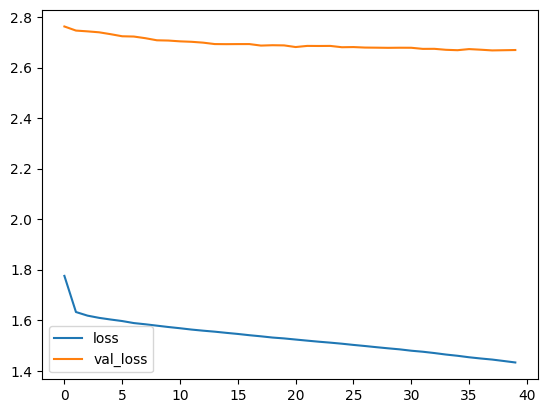

In [52]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

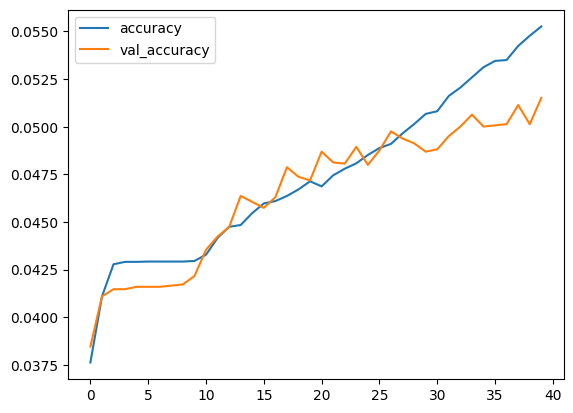

In [53]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

### Create a sampling model

In [54]:
# takes in english language sentences and return final lstm states; h and c or initial decoder states
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [55]:
# defining new inputs for initial decoder h and c
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# new input into embedding for the sequence len of 1 as I am generating one word at a time
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [57]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, 
                                     initial_state = decoder_states_inputs)

decoder_states = [h, c]

In [58]:
decoder_outputs = decoder_dense(decoder_outputs)

In [77]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, 
                      [decoder_outputs] + decoder_states)

# decoder_model.dtype

### Mapping indices to words

In [73]:
idx_to_word_eng = {idx_inputs:w_inputs for w_inputs, idx_inputs in word_to_idx_inputs.items()}

top_10_eng = dict(islice(idx_to_word_eng.items(), 10))
top_10_eng

{1: 'the',
 2: 'i',
 3: 'to',
 4: 'you',
 5: 'a',
 6: 'is',
 7: 'he',
 8: 'of',
 9: 'in',
 10: 'it'}

In [74]:
idx_to_word_trans = {idx_outputs:w_outputs for w_outputs, idx_outputs in word_to_idx_outputs.items()}

top_10_trans = dict(islice(idx_to_word_trans.items(), 10))
top_10_trans

{1: '<eos>',
 2: '<sos>',
 3: 'है।',
 4: 'नहीं',
 5: 'में',
 6: 'मैं',
 7: 'वह',
 8: 'से',
 9: 'मुझे',
 10: 'के'}